## 검은점 추출

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display
import os
import glob

In [ ]:
class SimpleBlackDotDetector:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        
        # 비디오 정보
        self.fps = int(self.cap.get(cv2.CAP_PROP_FPS))
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        print(f"비디오 정보: {self.width}x{self.height}, {self.fps}fps, {self.total_frames}프레임")
    
    def detect_black_dots(self, frame, dot_threshold=40, bg_threshold=150, min_area=15, max_area=500):
        """흰 배경의 검은 점만 검출"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # 1. 검은 영역 찾기
        _, black_mask = cv2.threshold(gray, dot_threshold, 255, cv2.THRESH_BINARY_INV)
        
        # 2. 노이즈 제거
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        black_mask = cv2.morphologyEx(black_mask, cv2.MORPH_OPEN, kernel)
        
        # 3. 컨투어 찾기
        contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        valid_dots = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if not (min_area < area < max_area):
                continue
            
            # 중심점과 크기 계산
            M = cv2.moments(contour)
            if M["m00"] == 0:
                continue
                
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            # 원형도 체크 (원에 가까운 것만)
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            
            if circularity < 0.4:  # 원형도가 낮으면 제외
                continue
            
            # 핵심: 주변이 충분히 밝은지 확인 (흰 배경 체크)
            if self._is_on_white_background(gray, cx, cy, area, bg_threshold):
                valid_dots.append({
                    'center': (cx, cy),
                    'area': area,
                    'circularity': circularity,
                    'contour': contour
                })
        
        return {
            'original': frame,
            'gray': gray,
            'black_mask': black_mask,
            'dots': valid_dots,
            'count': len(valid_dots)
        }
    
    def _is_on_white_background(self, gray, cx, cy, area, bg_threshold):
        """점 주변이 흰색 배경인지 확인"""
        # 점 크기에 비례한 검사 반경
        radius = int(np.sqrt(area / np.pi) * 2.5)  # 점 반지름의 2.5배
        
        # 경계 확인
        y1, y2 = max(0, cy - radius), min(gray.shape[0], cy + radius)
        x1, x2 = max(0, cx - radius), min(gray.shape[1], cx + radius)
        
        if y2 - y1 < 4 or x2 - x1 < 4:
            return False
        
        # 주변 영역의 밝기 평균
        surrounding = gray[y1:y2, x1:x2]
        
        # 중심 영역 제외하고 주변만 검사
        center_radius = max(2, radius // 3)
        mask = np.ones_like(surrounding, dtype=bool)
        cy_rel, cx_rel = radius, radius
        
        # 중심 부분 마스킹
        y_mask, x_mask = np.ogrid[:surrounding.shape[0], :surrounding.shape[1]]
        center_mask = (y_mask - cy_rel)**2 + (x_mask - cx_rel)**2 <= center_radius**2
        mask[center_mask] = False
        
        if np.sum(mask) == 0:
            return False
        
        # 주변 영역의 평균 밝기가 임계값보다 높아야 함 (밝은 배경)
        background_brightness = np.mean(surrounding[mask])
        return background_brightness > bg_threshold
    
    def visualize_detection(self, frame_num=0, dot_threshold=40, bg_threshold=150):
        """검출 과정 시각화"""
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = self.cap.read()
        
        if not ret:
            print(f"프레임 {frame_num}을 읽을 수 없습니다.")
            return
        
        # 검출 수행
        result = self.detect_black_dots(frame, dot_threshold, bg_threshold)
        
        # 결과 이미지 생성
        result_img = result['original'].copy()
        for i, dot in enumerate(result['dots']):
            cx, cy = dot['center']
            cv2.circle(result_img, (cx, cy), 8, (0, 255, 0), 2)
            cv2.putText(result_img, f"{i+1}", (cx+10, cy-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        axes[0,0].imshow(cv2.cvtColor(result['original'], cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('원본 이미지')
        axes[0,0].axis('off')
        
        axes[0,1].imshow(result['gray'], cmap='gray')
        axes[0,1].set_title('그레이스케일')
        axes[0,1].axis('off')
        
        axes[1,0].imshow(result['black_mask'], cmap='gray')
        axes[1,0].set_title(f'검은 영역 (임계값: {dot_threshold})')
        axes[1,0].axis('off')
        
        axes[1,1].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        axes[1,1].set_title(f'검출 결과 ({result["count"]}개 점)')
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 검출 정보 출력
        print(f"\n검출된 점들:")
        for i, dot in enumerate(result['dots']):
            cx, cy = dot['center']
            print(f"  점 {i+1}: 위치({cx}, {cy}), 면적={dot['area']:.0f}, 원형도={dot['circularity']:.2f}")
        
        return result
    
    def test_parameters(self, frame_num=0):
        """다양한 파라미터로 테스트"""
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = self.cap.read()
        
        if not ret:
            return
        
        # 파라미터 조합
        dot_thresholds = [30, 40, 50, 60]
        bg_thresholds = [120, 150, 180]
        
        fig, axes = plt.subplots(len(bg_thresholds), len(dot_thresholds), figsize=(16, 12))
        
        for i, bg_thresh in enumerate(bg_thresholds):
            for j, dot_thresh in enumerate(dot_thresholds):
                result = self.detect_black_dots(frame, dot_thresh, bg_thresh)
                
                # 결과 이미지
                img = result['original'].copy()
                for dot in result['dots']:
                    cx, cy = dot['center']
                    cv2.circle(img, (cx, cy), 6, (0, 255, 0), 2)
                
                axes[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[i,j].set_title(f'점임계값:{dot_thresh}, 배경임계값:{bg_thresh}\n검출수:{result["count"]}')
                axes[i,j].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def test_multiple_frames(self, num_frames=8):
        """여러 프레임에서 검출 테스트"""
        step = max(1, self.total_frames // (num_frames + 1))
        
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.flatten()
        
        detection_counts = []
        
        for i in range(min(num_frames, 8)):
            frame_num = (i + 1) * step
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = self.cap.read()
            
            if not ret:
                continue
            
            result = self.detect_black_dots(frame)
            detection_counts.append(result['count'])
            
            # 결과 이미지
            img = result['original'].copy()
            for dot in result['dots']:
                cx, cy = dot['center']
                cv2.circle(img, (cx, cy), 8, (0, 255, 0), 2)
            
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f'프레임 {frame_num}\n검출: {result["count"]}개')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        if detection_counts:
            print(f"검출 통계: 평균 {np.mean(detection_counts):.1f}개, "
                  f"최대 {max(detection_counts)}개, 최소 {min(detection_counts)}개")
    
    def show_original_video(self):
        """원본 비디오 표시"""
        return Video(self.video_path, width=400)
    
    def __del__(self):
        if hasattr(self, 'cap'):
            self.cap.release()

# 비디오 파일 찾기
def find_video_files():
    video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv']
    video_files = []
    for ext in video_extensions:
        video_files.extend(glob.glob(ext))
    return video_files

# 메인 실행
print("=== 흰 배경의 검은 점 검출기 ===")

video_files = find_video_files()
if not video_files:
    print("현재 디렉토리에 비디오 파일이 없습니다.")
else:
    print(f"비디오 파일: {video_files[0]}")
    detector = SimpleBlackDotDetector(video_files[0])
    
    print("\n원본 비디오:")
    display(detector.show_original_video())
    
    print("\n사용 가능한 명령어:")
    print("detector.visualize_detection(frame_num=0)  # 특정 프레임 검출")
    print("detector.test_parameters(frame_num=0)      # 파라미터 테스트") 
    print("detector.test_multiple_frames(num_frames=8) # 여러 프레임 테스트")

=== 특징점 검출 테스트 ===
발견된 비디오 파일: ['1.mp4', '2.mp4', '3.mp4']
비디오 정보:
- 해상도: 1920x1080
- FPS: 30
- 총 프레임: 667
- 길이: 22.23초

1. 원본 비디오 확인:
원본 비디오:


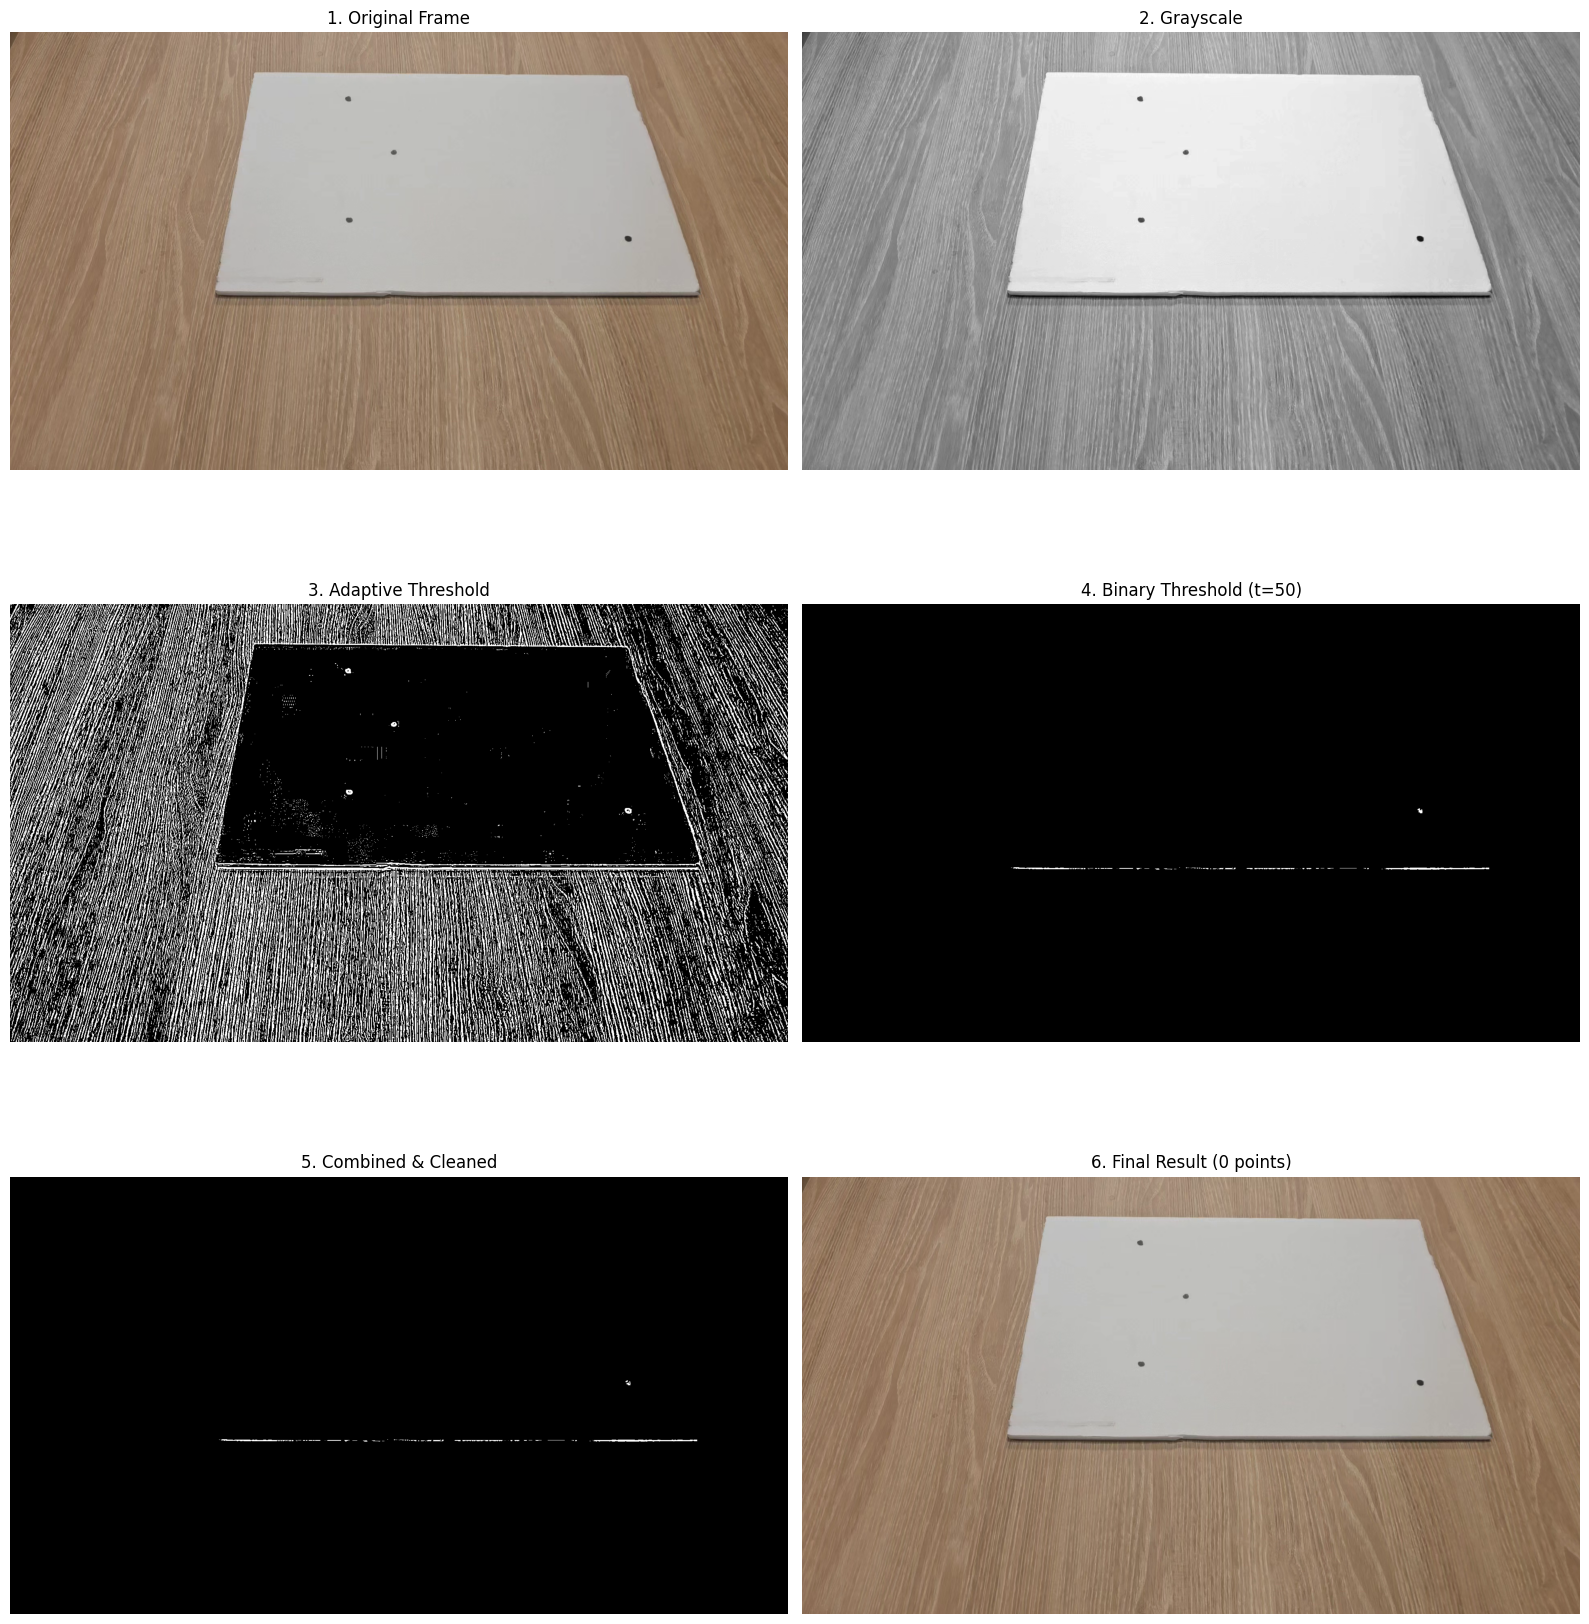

프레임 0: 검출된 점이 없습니다.


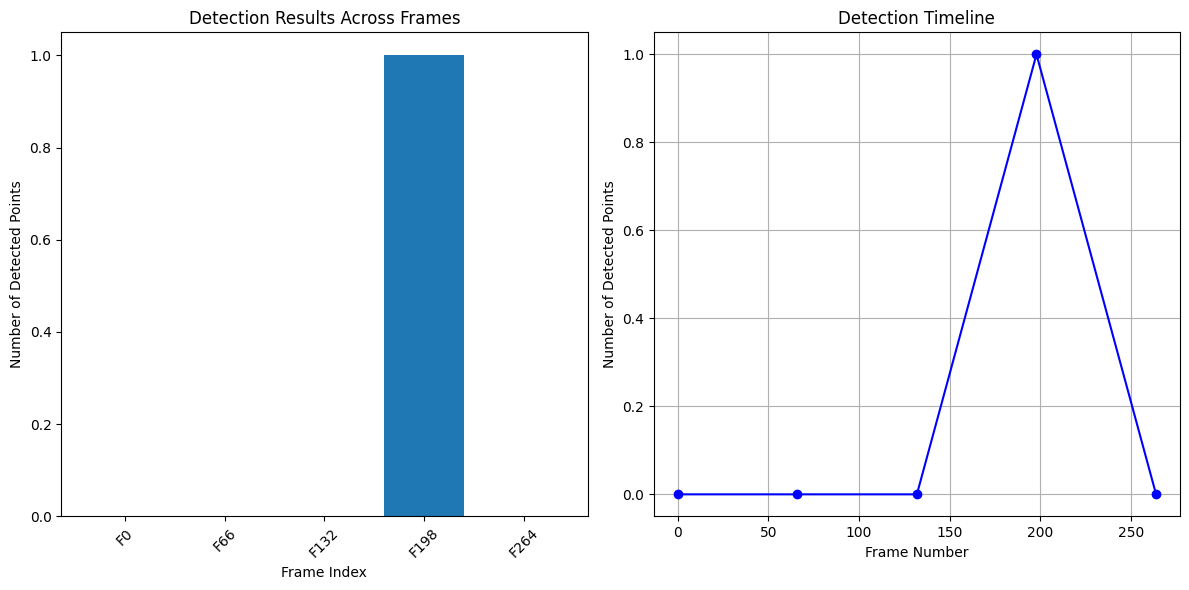

검출 결과 통계:
- 평균 검출 점 수: 0.2
- 최대 검출 점 수: 1
- 최소 검출 점 수: 0
- 검출 안정성 (표준편차): 0.4


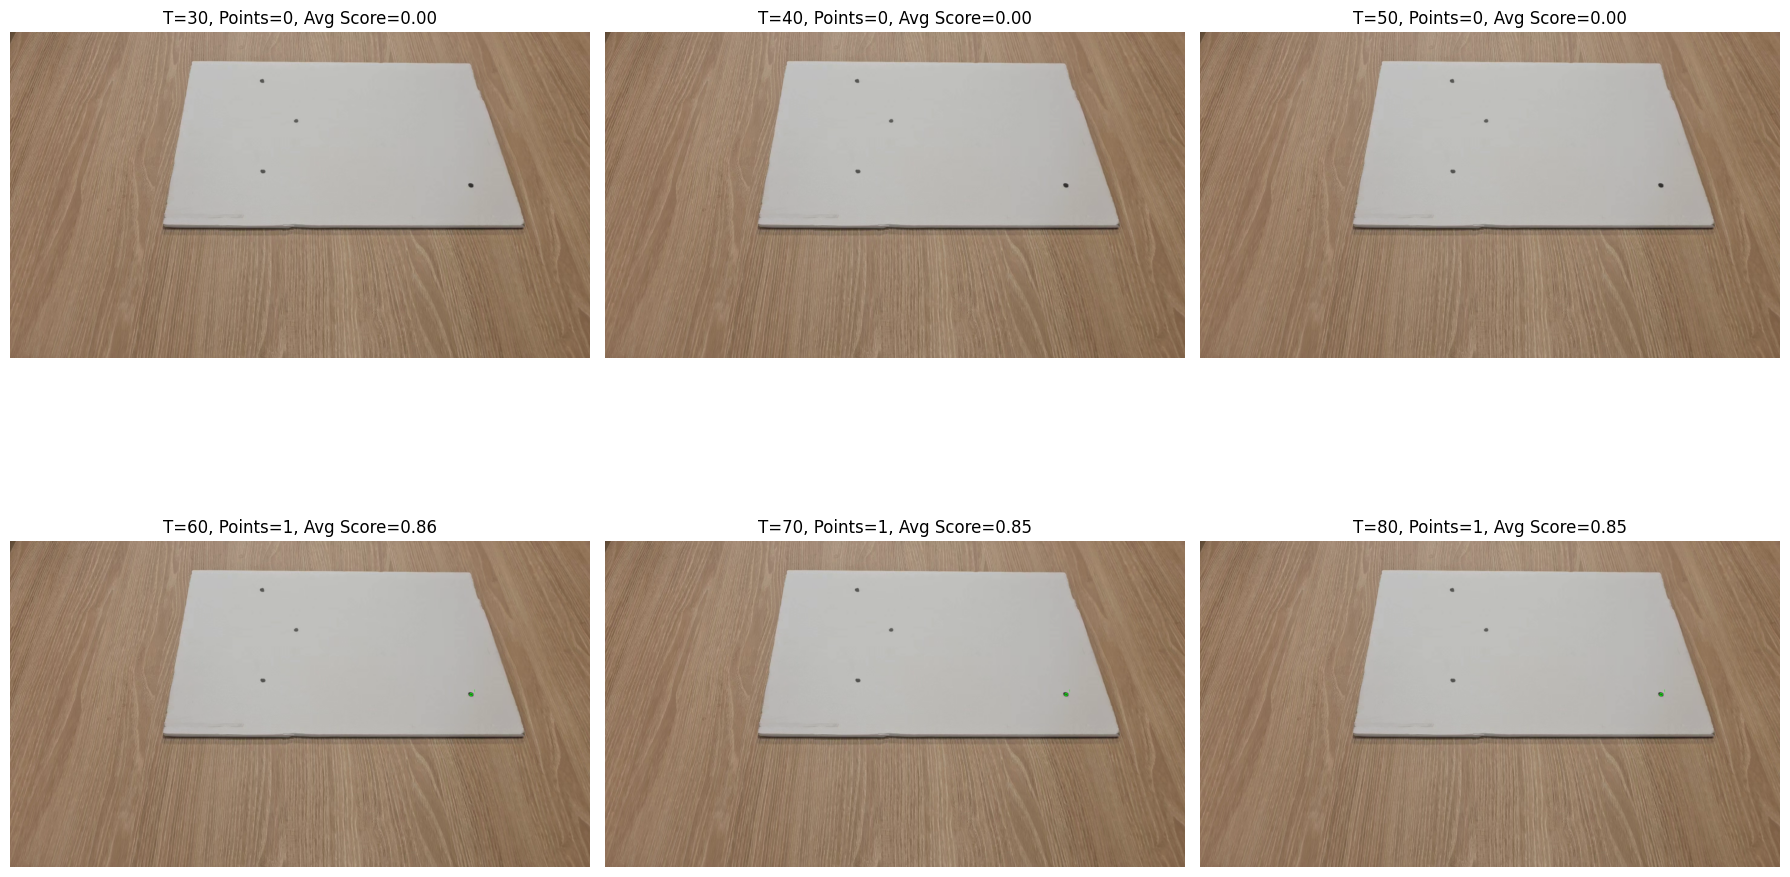

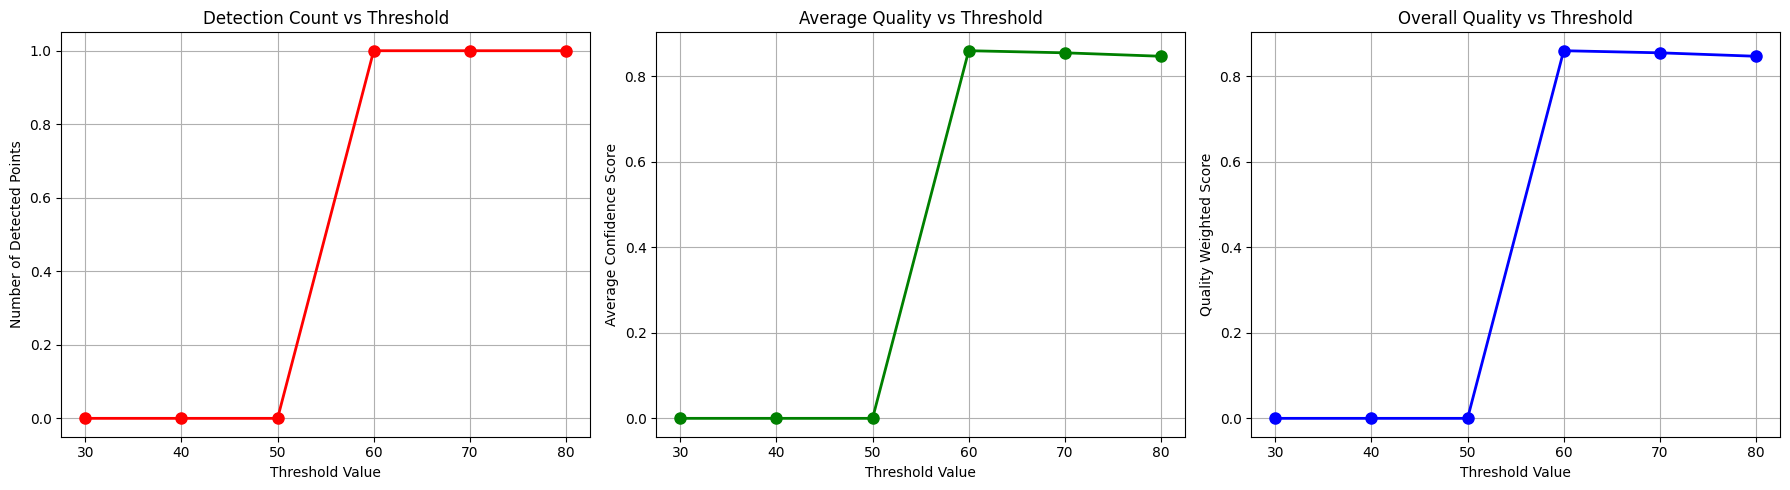

분석 결과:
- 최다 검출 임계값: 60 (검출 수: 1)
- 최고 품질 임계값: 60 (품질 점수: 0.86)
- 권장 임계값: 60 (품질과 개수를 모두 고려)


([30, 40, 50, 60, 70, 80],
 [0, 0, 0, 1, 1, 1],
 [0, 0, 0, 0.859856094749285, 0.8549497715781953, 0.8468745932797832])

In [7]:
# 1. 기본 검출 테스트
tester.visualize_detection_process(frame_num=0, threshold=50)

# 2. 여러 프레임 안정성 테스트  
tester.test_multiple_frames(num_frames=5)

# 3. 최적 임계값 찾기 (품질 가중 점수 포함)
tester.interactive_threshold_test(frame_num=0)

C:\Users\rigel\AppData\Local\Temp\ipykernel_16156\3376749116.py:129: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  plt.tight_layout()
C:\Users\rigel\AppData\Local\Temp\ipykernel_16156\3376749116.py:129: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  plt.tight_layout()
C:\Users\rigel\AppData\Local\Temp\ipykernel_16156\3376749116.py:129: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  plt.tight_layout()
C:\Users\rigel\AppData\Local\Temp\ipykernel_16156\3376749116.py:129: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  plt.tight_layout()
C:\Users\rigel\AppData\Local\Temp\ipykernel_16156\3376749116.py:129: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  plt.tight_layout()
C:\Users\rigel\AppData\Local\Temp\ipykernel_16156\3376749116.py:129: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from current font.
  plt.tig

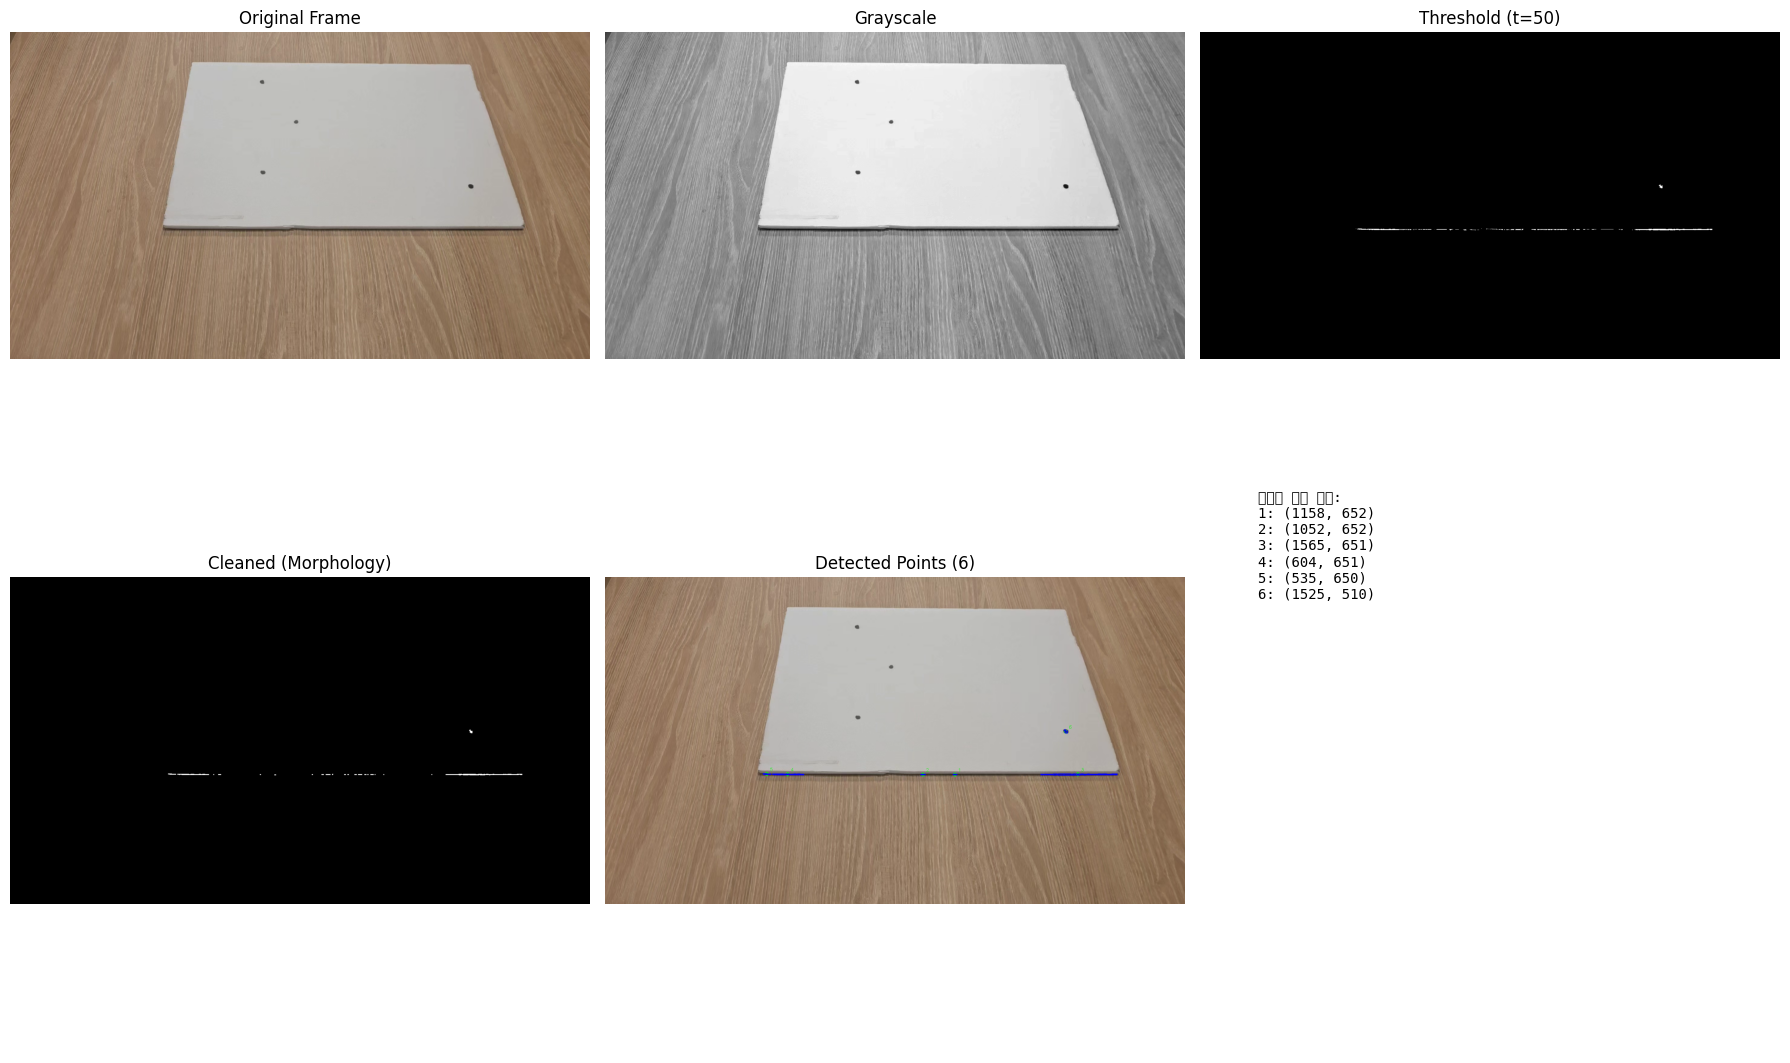

프레임 0: 6개의 검은 점 검출됨


{'original': array([[[ 66,  84, 106],
         [ 53,  71,  93],
         [ 48,  66,  88],
         ...,
         [ 85, 108, 139],
         [ 86, 109, 140],
         [ 87, 110, 141]],
 
        [[ 56,  74,  96],
         [ 51,  69,  91],
         [ 49,  67,  89],
         ...,
         [ 86, 109, 140],
         [ 86, 109, 140],
         [ 85, 108, 139]],
 
        [[ 53,  71,  93],
         [ 52,  70,  92],
         [ 50,  68,  90],
         ...,
         [ 86, 109, 140],
         [ 86, 109, 140],
         [ 84, 107, 138]],
 
        ...,
 
        [[ 86, 110, 139],
         [ 85, 109, 138],
         [ 85, 109, 138],
         ...,
         [ 74, 100, 130],
         [ 76, 103, 131],
         [ 78, 105, 133]],
 
        [[ 85, 109, 138],
         [ 85, 109, 138],
         [ 85, 109, 138],
         ...,
         [ 74, 100, 130],
         [ 77, 103, 133],
         [ 79, 105, 135]],
 
        [[ 84, 108, 137],
         [ 85, 109, 138],
         [ 85, 109, 138],
         ...,
         [ 75, 1

In [5]:
tester.visualize_detection_process(frame_num=0, threshold=50)